Start this up before you start reading

In [2]:
%pip install qiskit qiskit-ibm-runtime qiskit-aer
!pip install pylatexenc matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 24.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 45.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 36.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.4/39.4 MB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 324.1/324.1 kB 15.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 7.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     

# CNOT and Beyond

## Objectives
* Understand the CNOT and SWAP gates
* Start to get comfortable with QISKIT

While $CNOT$ plus appropriate $1q$ gates is a universal gate set, some hardware has difficutly implementing $CNOT$ directed. Further, theorist both for sloth and deeper reasons sometimes desire to work with other $2q$ gates.  We will investigate some of these gates today.

The lab is a heavily modifed combination of
https://qiskit.org/textbook/ch-gates/multiple-qubits-entangled-states.html
https://qiskit.org/textbook/ch-gates/phase-kickback.html
https://qiskit.org/textbook/ch-gates/more-circuit-identities.html

## Representing Multi-Qubit States

Describing the state of two qubits requires four complex amplitudes. We store these amplitudes in a 4D-vector like so:

$$ |a\rangle = a_{00}|00\rangle + a_{01}|01\rangle + a_{10}|10\rangle + a_{11}|11\rangle = \begin{bmatrix} a_{00} \\ a_{01} \\ a_{10} \\ a_{11} \end{bmatrix} $$

<b>If</b> we have two <b>unentangled</b> qubits, as we learned yesterday the coefficients $a_{ij}$ are not all independent.  Instead, there are only 4 free parameters and we can describe the state as a <b>tensor product</b>:

$$ |a\rangle = \begin{bmatrix} a_0 \\ a_1 \end{bmatrix}, \quad |b\rangle = \begin{bmatrix} b_0 \\ b_1 \end{bmatrix} $$

$$
|ba\rangle = |b\rangle \otimes |a\rangle = \begin{bmatrix} b_0 \times \begin{bmatrix} a_0 \\ a_1 \end{bmatrix} \\ b_1 \times \begin{bmatrix} a_0 \\ a_1 \end{bmatrix} \end{bmatrix} = \begin{bmatrix} b_0 a_0 \\ b_0 a_1 \\ b_1 a_0 \\ b_1 a_1 \end{bmatrix}
$$

And following the same rules, we can use the tensor product to describe the state of any number of qubits. Here is the $3q$ example:

$$
|cba\rangle = \begin{bmatrix} c_0 b_0 a_0 \\ c_0 b_0 a_1 \\ c_0 b_1 a_0 \\ c_0 b_1 a_1 \\
                              c_1 b_0 a_0 \\ c_1 b_0 a_1 \\ c_1 b_1 a_0 \\ c_1 b_1 a_1 \\
              \end{bmatrix}
$$

If we have $n$ qubits, we will need to keep track of an exponentially growing $2^n$ complex amplitudes. This is why quantum computers with large numbers of qubits are so difficult to classically simulate. A modern laptop can simulate a general quantum state of around 20 qubits, but simulating 100 qubits is too difficult for the largest supercomputers.

<b>Lets look at an example of this, using QISKIT.</b>

To do so, we need to import a bunch of modules into python, which we do in the next cell

In [3]:
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit_ibm_runtime.fake_provider import FakeNairobiV2
from qiskit.providers.fake_provider import GenericBackendV2
from qiskit.visualization import plot_histogram, plot_bloch_multivector
from math import pi
import numpy as np

For a simple example let us consider the state of 3 qubits where each is in the $|+\rangle$ state:

$$
|{+++}\rangle = \frac{1}{\sqrt{8}}\begin{bmatrix} 1 \\ 1 \\ 1 \\ 1 \\
                              1 \\ 1 \\ 1 \\ 1 \\
              \end{bmatrix}
$$

QISKIT, like IBM composer, starts all qubits into the $|0\rangle$.  <b>What operation do we perform to take and single qubit $|0\rangle\rightarrow \frac{1}{\sqrt{2}}|0\rangle+|1\rangle)=|+\rangle$?</b>

If want to prepare the tensor product $|{+++}\rangle$, we just need to repeat this gate for each of the three qubits.

How does QISKIT implement a circuit to perform this action?

The first thing we need to do is initialize a variable that will store the quantum circuit.  In QISKIT this is done by calling the function

    QuantumCircuit(n)

where n is the number of qubits we wish to use


In [4]:
## In this line, replace ??? with the number of qubits needed for the |+++> state
qc = QuantumCircuit(3)

To apply a single qubit gate, the syntax is

    name_of_circuit.name_of_gate(index_of_qubit)

So for example, to apply a Hadamard gate to the 3rd qubit in our code, we would write

    qc.h(3)
    
To change the $|000\rangle\rightarrow|+++\rangle$ state, we need to apply H to each of the 3 qubits.  One way to do that is

    qc.h(1)
    qc.h(2)
    qc.h(3)

* In the next cell, <b>rewrite this set into a single for loop</b>

In [13]:
# Apply H-gate to each qubit in a for loop:
for i in range(3):
  qc.h(i)


0 h [0]
1 h [1]
2 h [2]


┌───┐
q_0: ┤ H ├
     ├───┤
q_1: ┤ H ├
     ├───┤
q_2: ┤ H ├
     └───┘

An incredibly useful command to know for QISKIT is

    name_of_circuit.draw()
    
Which will draw the state ofthe circuit as currently encoded.

* <b>Visualize your circuit</b> in the next cell with the draw command

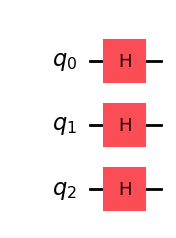

In [14]:
# See the circuit by using the draw command here:
qc.draw('mpl')


You might be worried about whether your code had in fact reproduced the correct state, $|+++\rangle$. We can check this by running a simulation.  To perform this, we need the following code:

In [15]:
## In this line, replace ??? with the number of qubits needed for the |+++> state
qc = QuantumCircuit(3)

# Apply H-gate to each qubit in a for loop:
for i in range(3):
  qc.h(i)

# See the circuit by using the draw command here:
qc.draw('mpl')

# This code defines a variable backend that will run the code. In order to perform simulations, which "backend" either simulator or
#real hardware it should use.  In this case, we want to use a 5-qubit device with linear connectivity
backend = GenericBackendV2(num_qubits=5,coupling_map=[[0,1],[1,2],[2,3],[3,4]])

# Here, we add a command to our circuit where after applying the previous part of our circuit.  This save_statevector()
# function literally saves the quantum state of the system.
qc.save_statevector()

# To run the simulator, we do [BACKEND].run([CIRCUIT]).  If we want to store the total output, we can use
# [BACKEND].run([CIRCUIT]).result() to obtain the results and store that information in a module.
# If we only want to store the wave function, we store [BACKEND].run([CIRCUIT]).get_statevector()
final_state = backend.run(qc).result().get_statevector()

This final variable has stored in it an array with the amplitudes of each of the 8 basis states.  We can print it in the standard way, or which an extract function, print it as a pretty latex array.

In [16]:
# In Jupyter Notebooks we can display this nicely using Latex.
# If not using Jupyter Notebooks you may need to remove the
# array_to_latex function and use print(final_state) instead.
from qiskit.visualization import array_to_latex
array_to_latex(final_state, prefix="\\text{Statevector} = ")

<IPython.core.display.Latex object>

How does your result compare to the theoretical $|+++\rangle$ we wrote above?

Now we know how to represent the state of multiple qubits, we are now ready to learn how qubits interact with each other. An important two-qubit gate is the CNOT-gate.

This matrix swaps the amplitudes of $|01\rangle$ and $|11\rangle$ in state vectors:

$$
|a\rangle = \begin{bmatrix} a_{00} \\ a_{01} \\ a_{10} \\ a_{11} \end{bmatrix}, \quad \text{CNOT}|a\rangle = \begin{bmatrix} a_{00} \\ a_{11} \\ a_{10} \\ a_{01} \end{bmatrix} \begin{matrix} \\ \leftarrow \\ \\ \leftarrow \end{matrix}
$$


This gate can be implemented with the code

    qc.cx(control_qubit,target_qubit)

To get a good sense of how this gate plays with others in the quantum computer, lets have it act on the state
$\frac{|00\rangle+|11\rangle}{\sqrt{2}}$.

* To do this, you first need to Hadamard $q0$
* Then add a CNOT onto $q1$ with $q0$ as the control.
* Finally, lets define the other functions we need and print the state vector

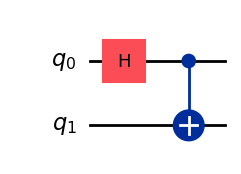

In [17]:
# Define a quantum circuit with only 2 qubits
qc2 = QuantumCircuit(2)


# Apply a Hadamard gate to q0
qc2.h(0)


# Apply a CNOT where the first qubit is a control and the second is a target.
# Remember that python starts indexing from 0
qc2.cx(0,1)

# Let's draw the circuit. Call the function here
qc2.draw('mpl')

In [18]:
# Here, we want to use a noiseless simulator, this can be gotten by defining our backend as AerSimulator()
backend_aer = AerSimulator()

# Repeat the necessary sets to add a save state to the circuit
qc2.save_statevector()

# Store the state vector itself into this variable
final_state_2 = backend_aer.run(qc2).result().get_statevector()

# Print the statevector neatly:
from qiskit.visualization import array_to_latex
array_to_latex(final_state_2, prefix="\\text{Statevector} = ")

<IPython.core.display.Latex object>

Does the state look the way you expected to expected? Convert it to ket notation, do you find:

$$
\text{CNOT}|0{+}\rangle = \tfrac{1}{\sqrt{2}}(|00\rangle + |11\rangle)
$$

* From scratch, can you write code to prepare, and print out the following state:
$$ |{-}{+}\rangle = \tfrac{1}{2}(|00\rangle + |01\rangle - |10\rangle - |11\rangle) $$ (Hint: You will need 2 Hadamards and 1 X gate)  
(Hint 2: Remember how the ordering of qubits is $|q_1 q_0\rangle$)
* Once you are happy, apply an additional CNOT where $q0$ is the control and $q1$ is the target and print the state.

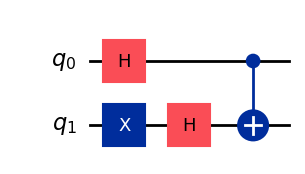

In [19]:
# Define a quantum circuit with only 2 qubits
qc3 = QuantumCircuit(2)

# Set q1 to |->
qc3.x(1)
qc3.h(1)

# Set q0 to |+>
qc3.h(0)

# Apply a CNOT where the first qubit is a control and the second is a target.
# Remember that python starts indexing from 0
qc3.cx(0,1)

# Let's draw the circuit. Call the function here
qc3.draw('mpl')


In [20]:
# Here, we want to use a noiseless simulator, this can be gotten by defining our backend as AerSimulator()
backend = AerSimulator()

# Repeat the necessary sets to add a save state to the circuit
qc3.save_statevector()

# Store the state vector itself into this variable
state = backend.run(qc3).result().get_statevector()

# Print the statevector neatly:
array_to_latex(state, prefix="\\text{Statevector} = ")

<IPython.core.display.Latex object>

What you hopefully observed is:

$$
\begin{aligned}
\text{CNOT}|{-}{+}\rangle & = \tfrac{1}{2}(|00\rangle - |01\rangle - |10\rangle + |11\rangle) \\
                           & = |{-}{-}\rangle
\end{aligned}
$$

This is interesting, because it affects the state of the _control_ qubit while leaving the state of the _target_ qubit unchanged.

If you remember the H-gate transforms $|{+}\rangle \rightarrow |0\rangle$ and $|{-}\rangle \rightarrow |1\rangle$, we can see that wrapping a CNOT in H-gates has the equivalent behavior of a CNOT acting in the opposite direction:



That's a pretty handy identity!  You might find it useful someday!


While the CNOT is nice, its not the only gate we might like to consider. Another common gate we talk about is the SWAP gate


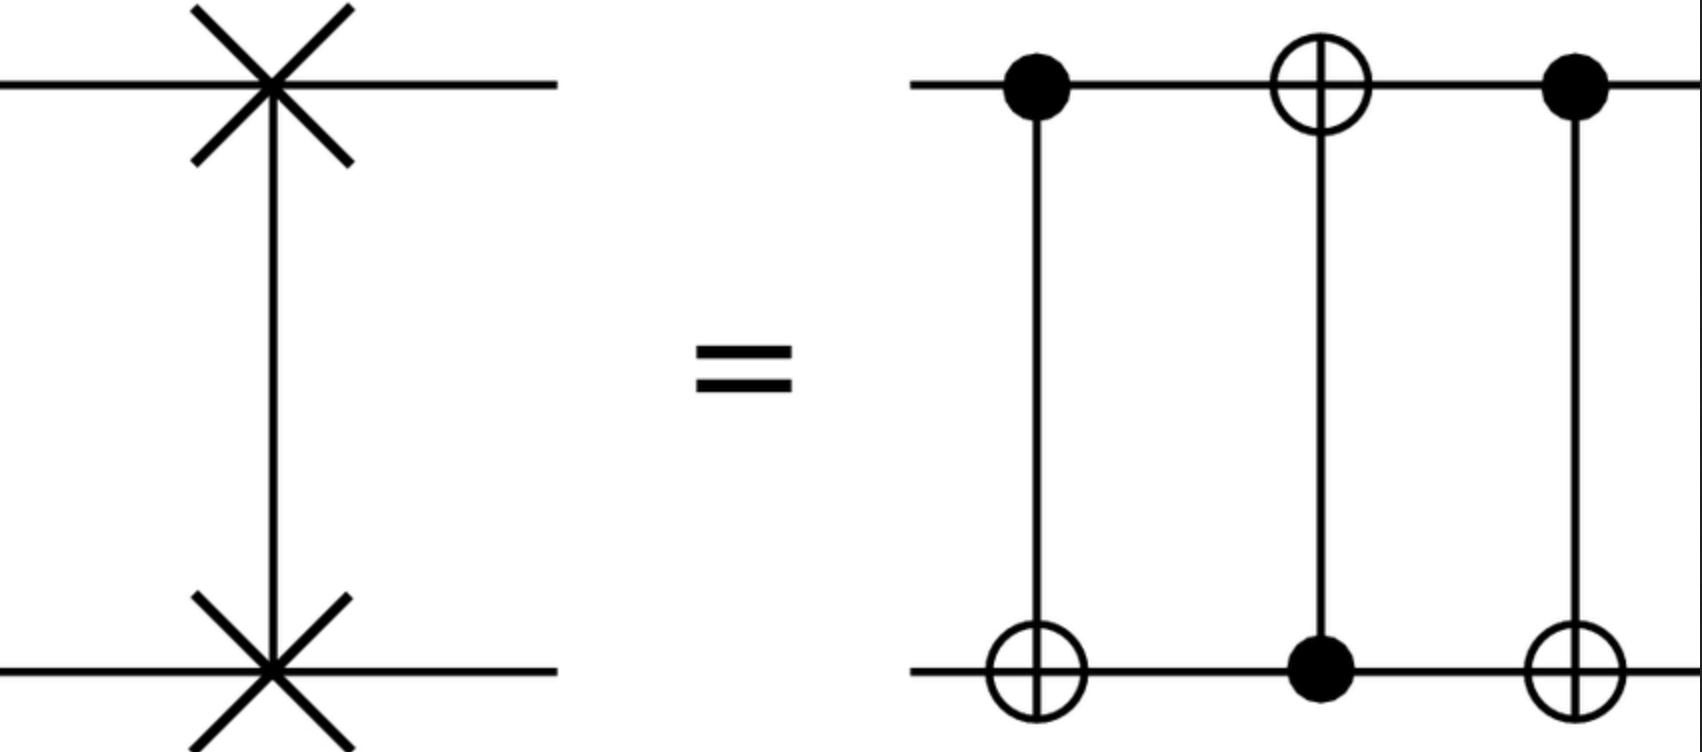

$$SWAP = \begin{pmatrix}1&0&0&0\\
                        0&0&1&0\\
                        0&1&0&0\\
                        0&0&0&1\\
\end{pmatrix}$$

Based on its name, I hope you could guess that what this gate does is to flip the states of the two qubits.

This gate can be called in QISKIT by:
   
       name_of_circuit.swap(qubit_1,qubit_2)

In order for the states to swap, $q_0$ and $q_1$ should be in different states. So how about you initialize them into a few different states and see if your intuition about SWAP gate works.  For each of these, you will be changing the next cell only in the part about "#Set up the initial state here'

* Set $q_0=|1\rangle$ by applying a X gate to it (Hint X gates can be implemented by "qc.x(qubit)") and run the code
* Move the X gate from $q_0$ to $q_1$ and rerun.
* Remove the X gate.  Set $q_0=|+\rangle$ (Do you remember what single gate takes $|0\rangle\rightarrow |+\rangle$) and rerun the code.
* Finally, prepare the state $|q_1 q_0\rangle=|-+\rangle$  and rerun your code.  

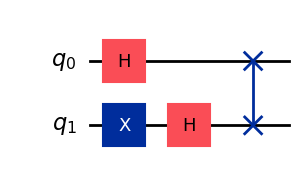

In [46]:
#Create a circuit
qC = QuantumCircuit(2)
#Set up the initial state here
qC.h(0)
qC.x(1)
qC.h(1)

# Apply SWAP-gate to each qubit:
qC.swap(0,1)

#Check your circuit with a draw
qC.draw('mpl')

In [47]:
# Let's see the result
backend = AerSimulator()
qC.save_statevector()
final_state = backend.run(qC).result().get_statevector()

array_to_latex(final_state, prefix="\\text{Statevector} = ")

<IPython.core.display.Latex object>

This morning, we learned in the lab that the quantum computer's connectivity effects how efficient the circuit can be transpiled to.  If two qubits don't have direct connections to each other, it is necessary to swap them along the path until they are together.

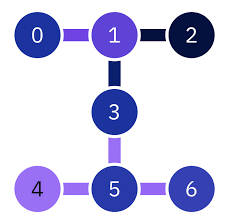

On a now retired computer, <b>ibmq_jakarta</b> suppose you wanted to have a CNOT|$q_2q_0\rangle$.  From the picture above, you should see that these two qubits can't directly talk.  Therefore in order to perform your calcualtion, you need to SWAP one of them with $q_1$, perform your CNOT, and then SWAP back.  <b>This is clearly more expensive.</b>  But it's actually worse than you think!  IBM computers don't have a native SWAP gate, instead you need to transpile it.


<b>Try this yourself in the next cell:</b>

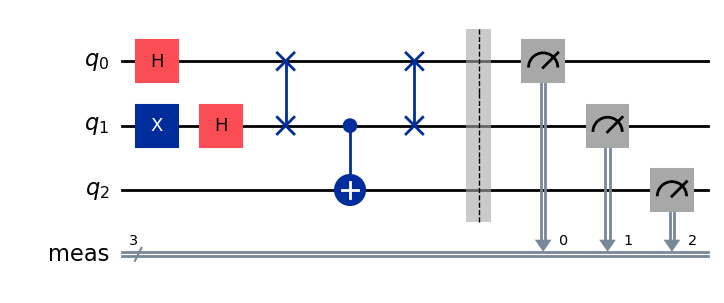

In [39]:
#Create me a circuit
qc = QuantumCircuit(3)

#Set up the initial state here
qc.h(0)
qc.x(1)
qc.h(1)

# Swap q0 and q1
qc.swap(0,1)

# Peform your CNOT on swapped qubits
qc.cx(1,2)

# Swap the qubits back
qc.swap(0,1)

# Measure all the qubits
qc.measure_all()
#Draw your result
qc.draw('mpl')


Let's check out this optimized puppy

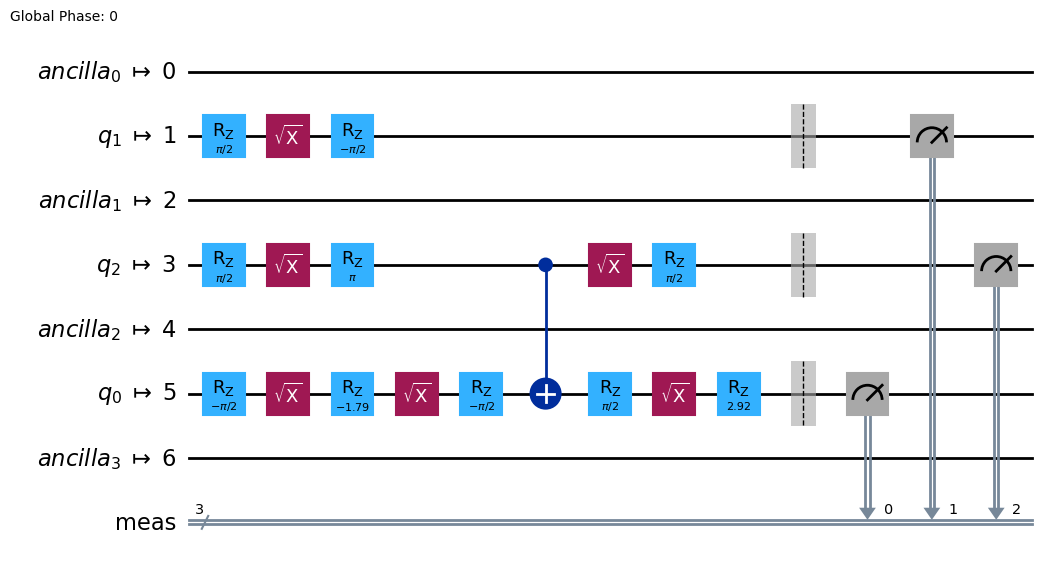

In [40]:
backend = GenericBackendV2(num_qubits=7,coupling_map=[[0,1],[1,2],[1,3],[3,5],[4,5],[5,6]])

pm = generate_preset_pass_manager(backend=backend, optimization_level=3)
transpiled_circuit = pm.run(qc)

transpiled_circuit.draw('mpl')

Let's run and see what we get

<ipython-input-41-a9f80aae46c4>:5: DeprecationWarning: The 'backend' keyword arguments are deprecated as of qiskit-ibm-runtime 0.24.0 and will be removed no sooner than 3 months after the release date. Please use the 'mode' parameter instead.
  sampler = Sampler(backend=backend, options=options)


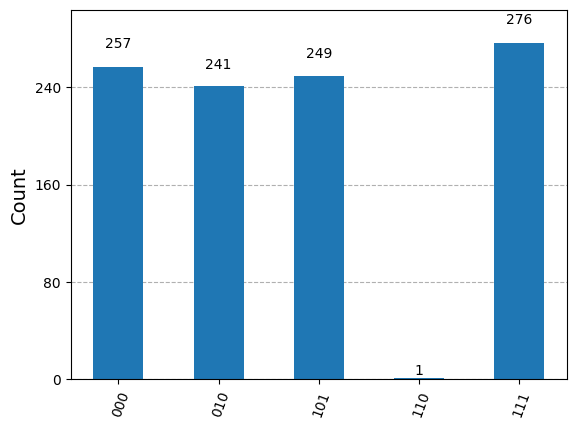

In [41]:
# You can use a fixed seed to get fixed results.
options = {"simulator": {"seed_simulator": 1989}}

#Set up the Sampler simulater backend
sampler = Sampler(backend=backend, options=options)

#Run the circuits, and get results
result = sampler.run([transpiled_circuit]).result()

#Plot the result
plot_histogram(result[0].data.meas.get_counts())